In [2]:
import sys
sys.path.append('..')

import utils

In [118]:
import pandas as pd
import seaborn as sns
import time
import re
from pandas import ExcelWriter
from datetime import datetime
import os
from functools import reduce 
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#### Directory of the file you want to postprocess

In [141]:
os.chdir(r"C:\Users\Desi\Desktop/TesiStanford/keithley_results") # path where the results are stored
path =  os.getcwd()
directory = '02082024-d012324-DiodeConnected_SensingTest-AS-Cortisol' # name of the directory you want to analyze
file = '02082024-d012324-DiodeConnected_SensingTestr3c2-AS-1uM.xlsx' # name of the file you want to import

In [142]:
analysis = 'aptamer'
conc = ['baseline','1pM','10pM','100pM','1nM','10nM','100nM','1uM'] if analysis=='aptamer' else ['baseline','1mM','2mM','4mM','8mM','16mM','32mM'] if analysis=='K' else ['baseline','10mM','20mM','40mM','80mM','160mM']

# Postprocessing

In [143]:
df = [pd.read_excel(str(os.getcwd())+'\\'+directory+'\\'+file, 'step #'+k) for k in conc]

In [144]:
# in case of read_xls - setting the Unnamed: 0 column as index and creating again a list of df
df = [i.rename(columns = {'Unnamed: 0': 'datapoint'}).set_index('datapoint') for i in df]
lists_of_df = [[df_conc.iloc[j:j+df_conc.index.max()+1] for i,j in enumerate(range(0, len(df_conc), df_conc.index.max()+1))] for df_conc in df]


In [145]:
diode_dict_list = {}
diode_df_dict = {}
for i,concen in enumerate(conc):
    diode_dict_list[concen] = lists_of_df[i]
    diode_df_dict[concen] = pd.concat(lists_of_df[i])

#### Defining the mean and the std for |VDl-VDR|, VDR and VDL, for the last Nvalues of the last Nsubgroup steps

In [146]:
Nsubgroup = 6
Nvalues = 5

mean_std = [[np.mean([(subdf['VDL'].iloc[-Nvalues:]-subdf['VDR'].iloc[-Nvalues:]).values for subdf in diode_df[-Nsubgroup:]])*1000,np.std(np.mean([abs(subdf['VDL'].iloc[-Nvalues:]-subdf['VDR'].iloc[-Nvalues:]).values for subdf in diode_df[-Nsubgroup:]],1))*1000] for diode_df in lists_of_df]
mean_std_L = [[np.mean([subdf['VDL'].iloc[-Nvalues:].values for subdf in df_conc[-Nsubgroup:]])*1000,np.std(np.mean([subdf['VDL'].iloc[-Nvalues:].values for subdf in df_conc[-Nsubgroup:]],1))*1000] for df_conc in lists_of_df]
mean_std_R = [[np.mean([subdf['VDR'].iloc[-Nvalues:].values for subdf in df_conc[-Nsubgroup:]])*1000,np.std(np.mean([subdf['VDR'].iloc[-Nvalues:].values for subdf in df_conc[-Nsubgroup:]],1))*1000] for df_conc in lists_of_df]

# subtracting the baseline to all the mean_std
mean_std = [[i[0]-mean_std[0][0],i[1]] for i in mean_std]
mean_std_L = [[i[0]-mean_std_L[0][0],i[1]] for i in mean_std_L]
mean_std_R = [[i[0]-mean_std_R[0][0],i[1]] for i in mean_std_R]

#### Creating a dataframe with all the mean and std

In [22]:
mean_std = pd.DataFrame(mean_std).rename(columns={0: 'mean [mV]', 1: 'std [mV]'})
mean_std['mean_L [mV]'] = [i[0]-mean_std_L[0][0] for i in mean_std_L]
mean_std['std_L [mV]'] = [i[1] for i in mean_std_L]
mean_std['mean_R [mV]'] = [i[0]-mean_std_R[0][0] for i in mean_std_R]
mean_std['std_R [mV]'] = [i[1] for i in mean_std_R]

In [23]:
mean_std

,mean [mV],std [mV],mean_L [mV],std_L [mV],mean_R [mV],std_R [mV]
0,0.000000,0.382172,0.000000,1.542412,0.000000,1.363068
1,-0.643333,0.278727,-6.260000,0.810987,-5.616667,0.763799
2,-1.960000,0.463669,-11.233333,1.393864,-9.273333,1.480360
3,-2.576667,0.413602,-17.683333,0.929205,-15.106667,1.194190
4,-4.596667,0.347179,-24.673333,1.113698,-20.076667,1.244102
5,-4.800000,0.509171,-33.466667,0.931266,-28.666667,0.631365
6,-6.490000,0.616838,-41.323333,0.906544,-34.833333,0.877192
7,-8.160000,0.803361,-45.716667,1.120635,-37.556667,1.024917


#### saving the table in an xlsx file

In [38]:
path = "C:\Users\Desi\Desktop\TesiStanford\keithley_results"
directory = '\02142024-d012324-DiodeConnected_SensingTest-IonSelectiveK'
file_name = '\mean_std_d012324-r3c2-Ksensing'
mean_std.to_excel(path+directory+file_name+'.xlsx')

# End of postprocessing

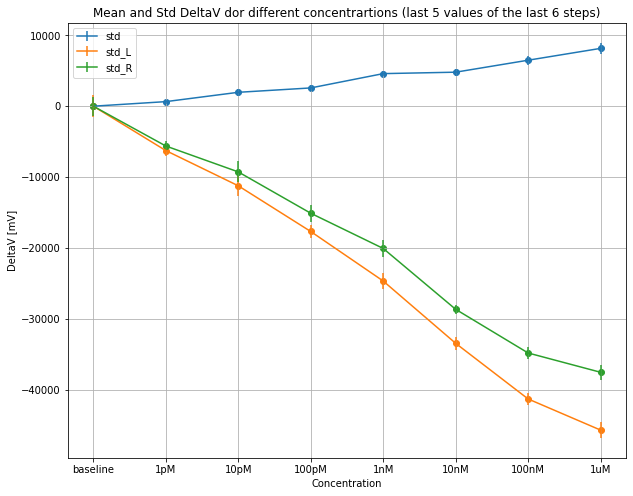

In [147]:
utils.plot_mean_std(8, mean_std_L,mean_std_R, [[abs(i[0]),i[1]] for i in mean_std], conc, 'r3c2')

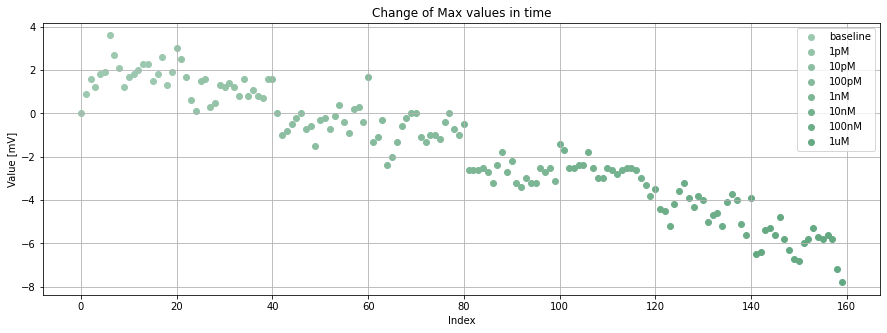

In [148]:
utils.plot_max_values(diode_df_dict, conc, 'r1c2','baseline','','', mode = 1)

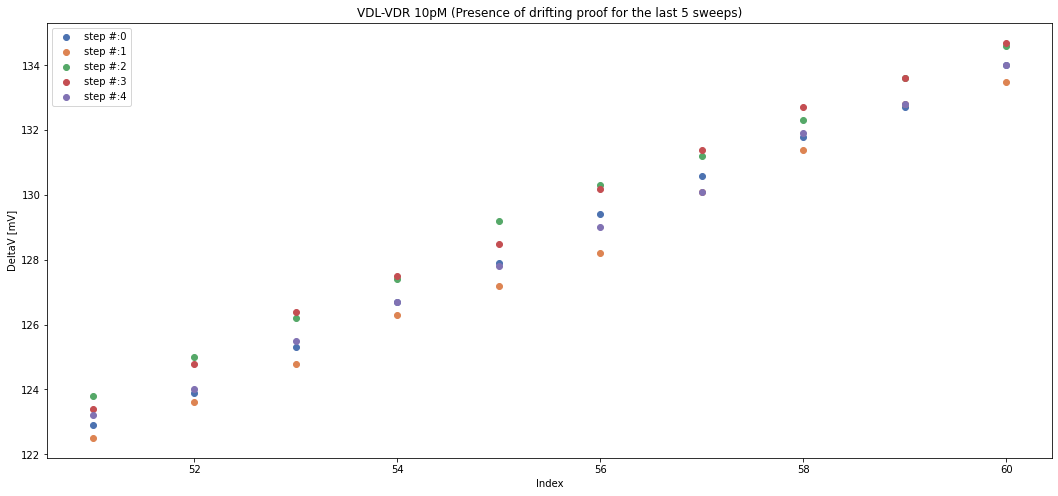

In [149]:
# plotting the 20 steps for the specific concentration
colors_diff_step = sns.color_palette("deep",20)
concentration = conc[2]
subset_dfs = diode_dict_list[concentration]

fig, ax = plt.subplots(figsize = (18,8))
for i,df in enumerate(subset_dfs[-5:]):
    ax.scatter(df.index[-10:], (df.iloc[-10:]['VDL']-df[-10:]['VDR'])*1000, label = 'step #:'+str(i), color = colors_diff_step[i])


ax.set_xlabel('Index')
ax.set_ylabel('DeltaV [mV]')
ax.legend()
plt.title('VDL-VDR ' + concentration + ' (Presence of drifting proof for the last 5 sweeps)')
plt.show()

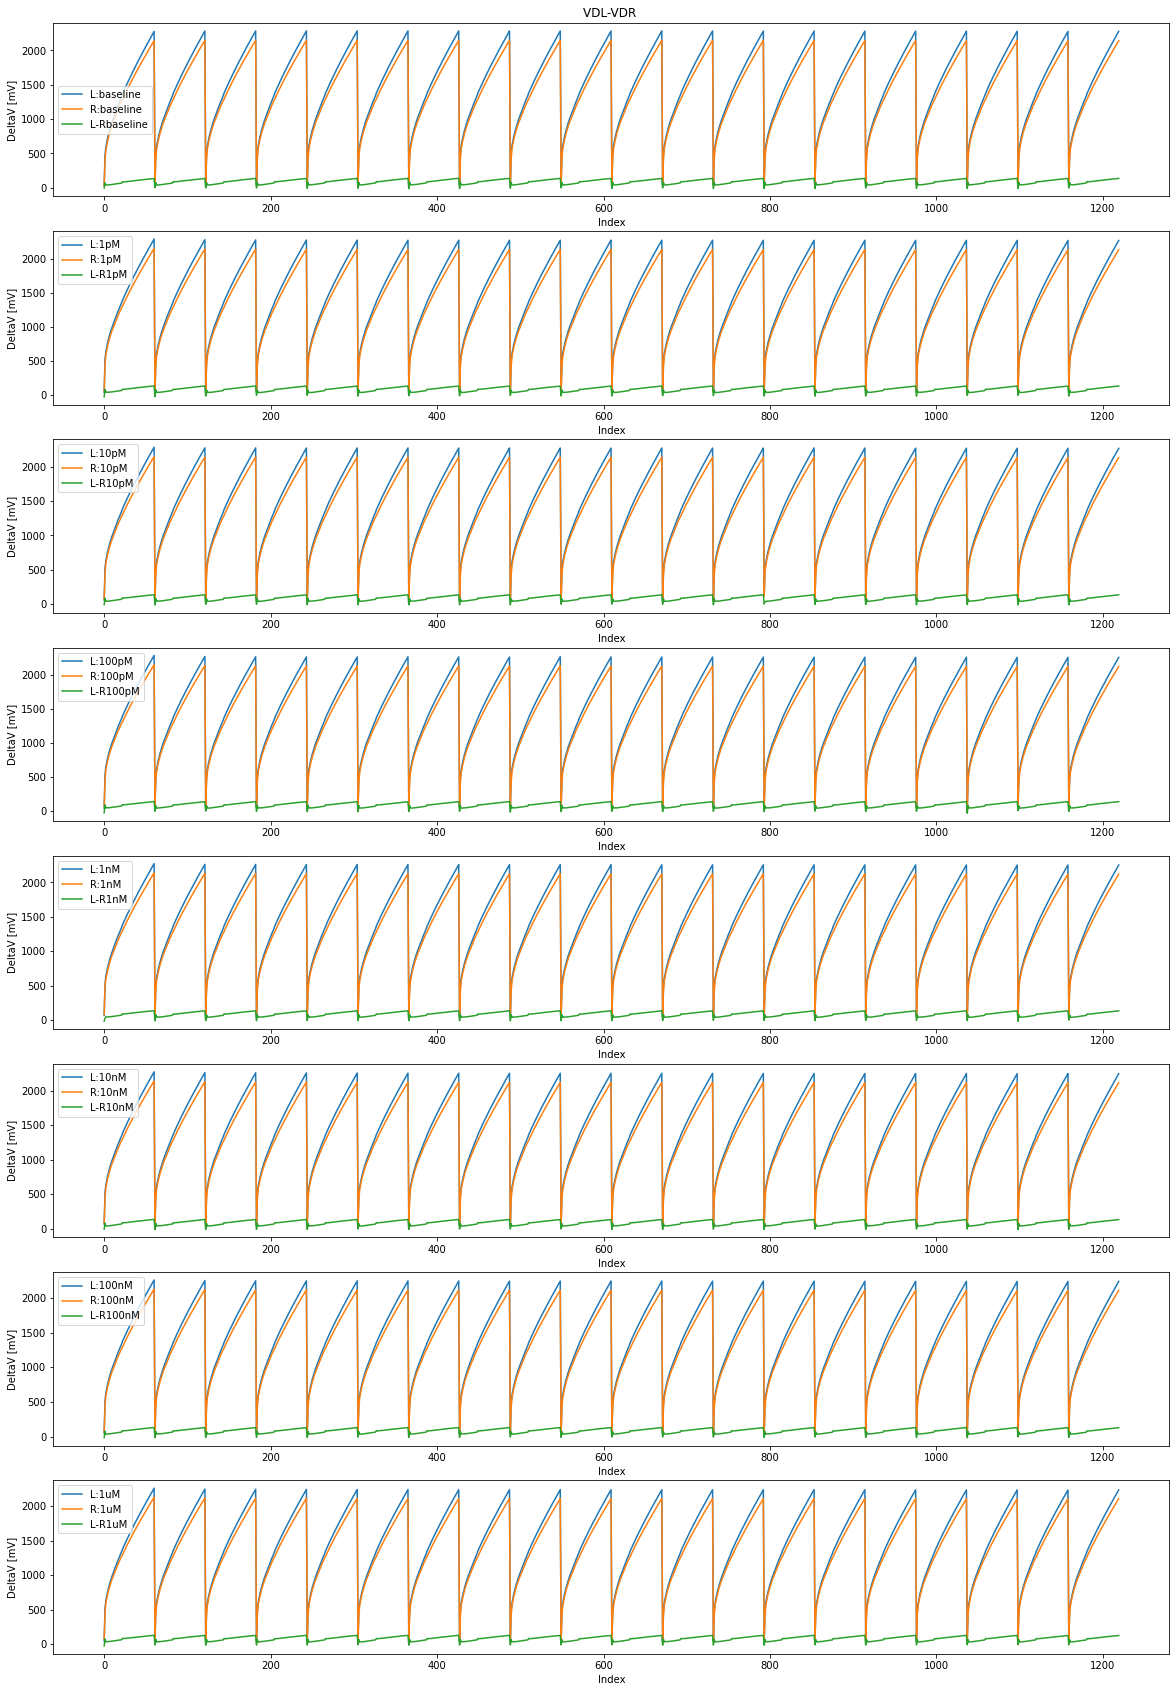

In [150]:
fig, ax = plt.subplots(8,1,figsize = (20,30))
ax[0].set_title('VDL-VDR ')
for nu in range(len(conc)):
    ax[nu].plot(diode_df_dict[conc[nu]].reset_index().index, (diode_df_dict[conc[nu]]['VDL'])*1000, label = 'L:'+str(conc[nu]))
    ax[nu].plot(diode_df_dict[conc[nu]].reset_index().index, (diode_df_dict[conc[nu]]['VDR'])*1000, label = 'R:'+str(conc[nu]))

    ax[nu].plot(diode_df_dict[conc[nu]].reset_index().index, (diode_df_dict[conc[nu]]['VDL']-diode_df_dict[conc[nu]]['VDR'])*1000, label = 'L-R'+str(conc[nu]))
    ax[nu].set_xlabel('Index')
    ax[nu].set_ylabel('DeltaV [mV]')
    ax[nu].legend()


plt.show()

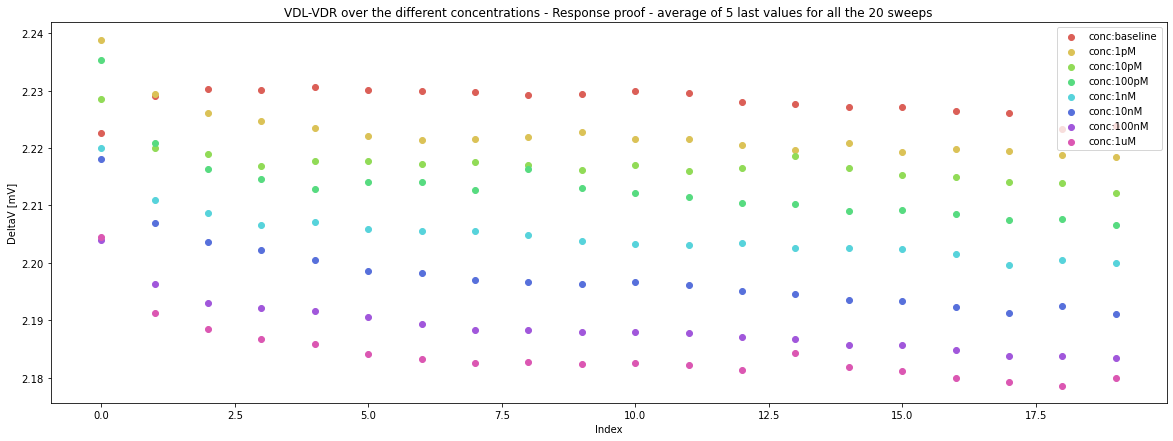

In [151]:
fig, ax = plt.subplots(figsize = (20,7))
colors_diff = sns.color_palette("hls", 8)
for i,conce in enumerate(conc):
    medie_gruppi = []
    lista_numeri = diode_df_dict[conce][diode_df_dict[conce].index.isin(range(55, 61))]['VDL']
    dimensione_gruppo = 6
    for j in range(0, len(lista_numeri), dimensione_gruppo):
        gruppo = lista_numeri[j:j+dimensione_gruppo]
        media_gruppo = sum(gruppo) / len(gruppo)
        medie_gruppi.append(media_gruppo)
    
    #ax.scatter(range(0,20), (diode_df_dict[conce][diode_df_dict[conce].index == 60]['VDL']-diode_df_dict[conce][diode_df_dict[conce].index == 60]['VDR'])*1000, label = 'conc:'+conc[i], color = colors_diff[i])
    ax.scatter(range(0,20), medie_gruppi, label = 'conc:'+conc[i], color = colors_diff[i])
ax.set_xlabel('Index')
ax.set_ylabel('DeltaV [mV]')
ax.legend()
plt.title('VDL-VDR over the different concentrations - Response proof - average of 5 last values for all the 20 sweeps')
plt.show()

In [152]:
# taking the last 5 sweeps and took the average of all the curves
average_5sweeps = pd.DataFrame()
for concen in conc: 
    average_5sweeps[concen] = np.mean(pd.concat([i['VDL']*1000 for i in diode_dict_list[concen][15:]], axis = 1),axis=1)

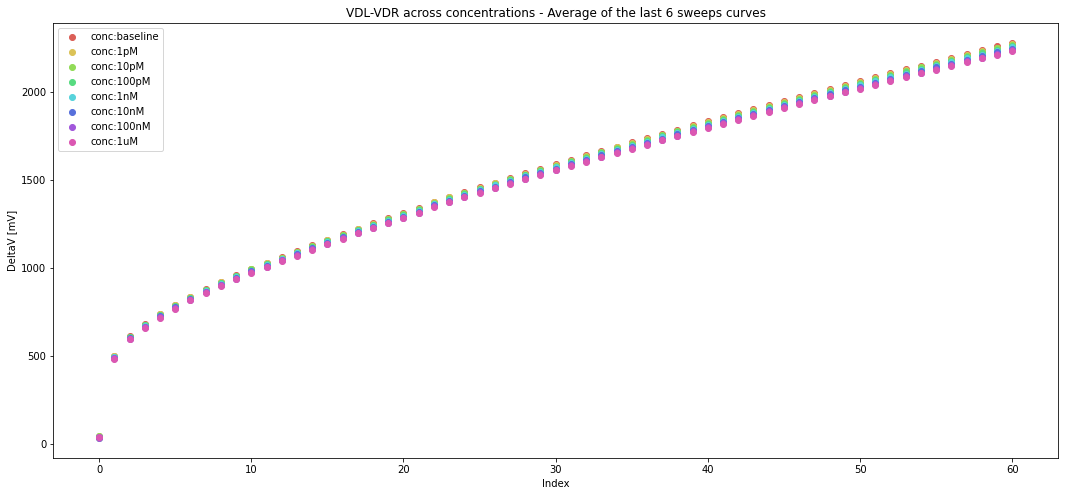

In [153]:
# plotting the 20 steps for the specific concentration

#subset_size = df1pM_.index.max()
#subset_dfs = [df1pM_.iloc[i:i + subset_size] for i in range(0, len(df1pM_), subset_size)] # we need this when we read_csv

fig, ax = plt.subplots(figsize = (18,8))
for i,concen in enumerate(conc):
    #ax.scatter(diode_dict_list[concen][15].index, (diode_dict_list[concen][15:]['VDL'].mean()-diode_dict_list[concen][15:]['VDR'].mean())*1000, label = 'conc:'+str(concen), color = colors_diff[i])
    ax.scatter(diode_dict_list[concen][15].index, average_5sweeps[concen], label = 'conc:'+str(concen), color = colors_diff[i])
ax.set_xlabel('Index')
ax.set_ylabel('DeltaV [mV]')
ax.legend()
plt.title('VDL-VDR across concentrations - Average of the last 6 sweeps curves')
plt.show()

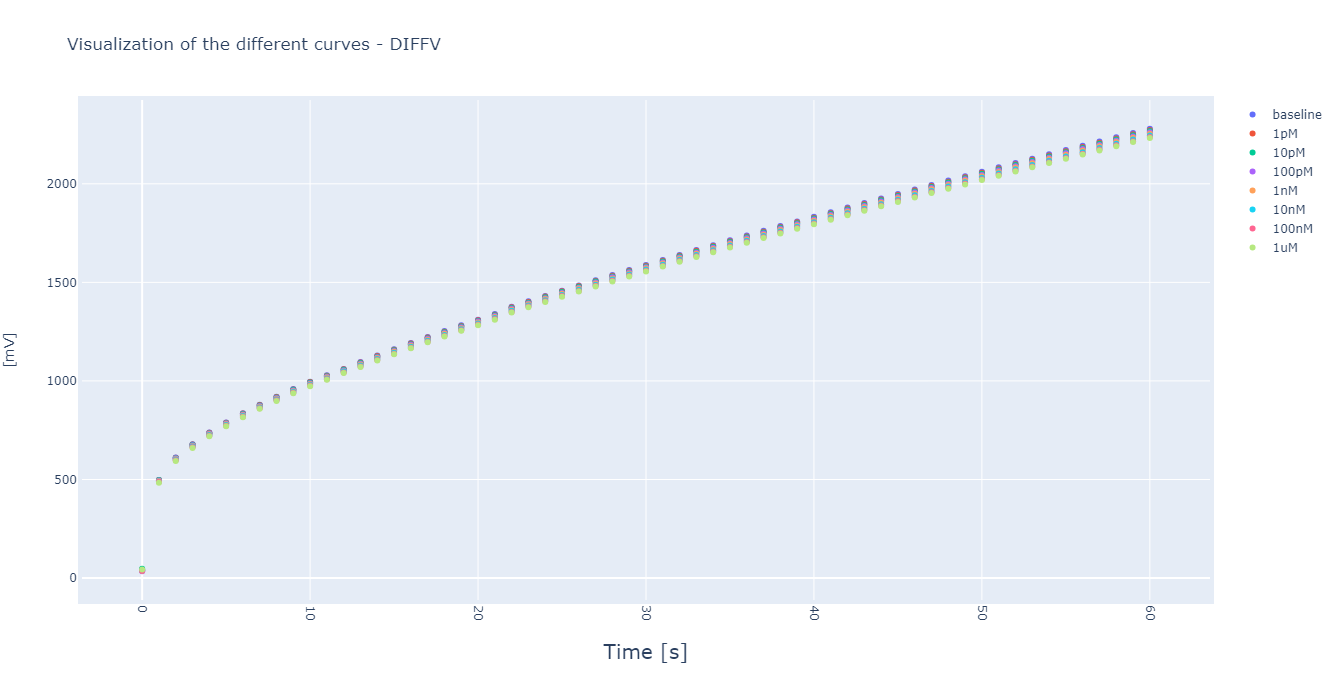

<Figure size 720x720 with 0 Axes>

In [161]:
plt.figure(figsize=(10,10))
fig = go.Figure()
x = average_5sweeps
fig.add_traces([go.Scatter(x=x.index, y=x[i], mode='markers',name = i) for i in conc])

fig.update_layout(
    autosize=False,
    width=1200,
    height=700,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    title = 'Visualization of the different curves - DIFFV'
)

fig.update_xaxes(
        tickangle = 90,
        title_text = "Time [s]",
        title_font = {"size": 20},
        title_standoff = 25)

fig.update_yaxes(
        title_text = "[mV]",
        title_standoff = 25)
#plt.savefig(r'C:\Users\Desi\Desktop\TesiStanford\Nasensing\MaxDiffVAcrossConcentrations.png')
fig.show()

In [163]:
colors_L = sns.color_palette("Blues",3)
colors_R = sns.color_palette("YlOrBr",3)

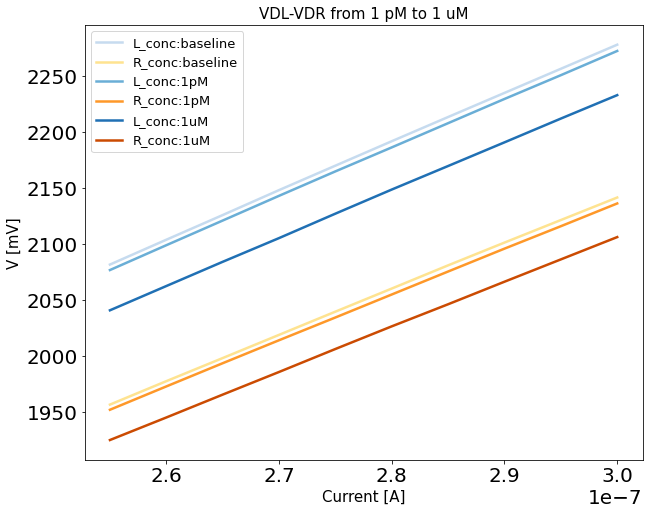

In [165]:
fig, ax = plt.subplots(figsize = (10,8))
#for i,df in enumerate(subset_dfs):
for i,concen in enumerate([0,1,-1]):
    ax.plot(lists_of_df[concen][-1]['IDL'].iloc[-10:], (lists_of_df[concen][-1]['VDL'].iloc[-10:])*1000, label = 'L_conc:'+str(conc[concen]), color = colors_L[i], linewidth = 2.5)
    ax.plot(lists_of_df[concen][-1]['IDR'].iloc[-10:], (lists_of_df[concen][-1]['VDR'].iloc[-10:])*1000, label = 'R_conc:'+str(conc[concen]), color = colors_R[i], linewidth = 2.5)

ax.set_xlabel('Current [A]',fontsize = 15)
ax.set_ylabel('V [mV]',fontsize = 15)
ax.legend(fontsize = 13)
plt.title('VDL-VDR from 1 pM to 1 uM',fontsize = 15)
plt.rcParams.update({'font.size': 20})
plt.show()

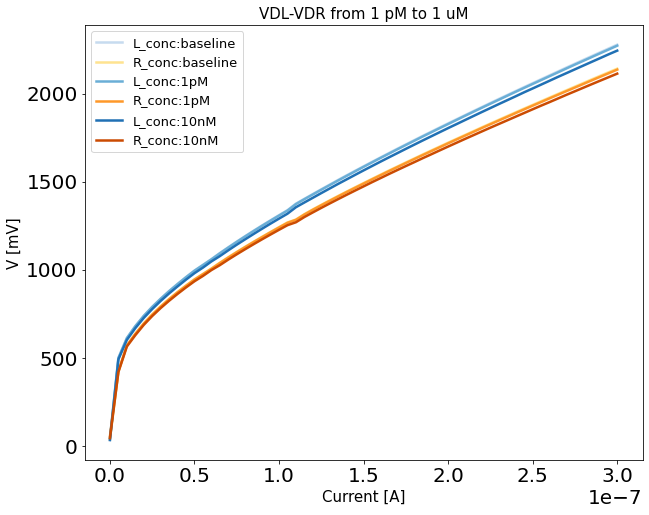

In [31]:
fig, ax = plt.subplots(figsize = (10,8))
#for i,df in enumerate(subset_dfs):
for i,concen in enumerate([0,1,-3]):
    ax.plot(lists_of_df[concen][-1]['IDL'], (lists_of_df[concen][-1]['VDL'])*1000, label = 'L_conc:'+str(conc[concen]), color = colors_L[i], linewidth = 2.5)
    ax.plot(lists_of_df[concen][-1]['IDR'], (lists_of_df[concen][-1]['VDR'])*1000, label = 'R_conc:'+str(conc[concen]), color = colors_R[i], linewidth = 2.5)

ax.set_xlabel('Current [A]',fontsize = 15)
ax.set_ylabel('V [mV]',fontsize = 15)
ax.legend(fontsize = 13)
plt.title('VDL-VDR from 1 pM to 1 uM',fontsize = 15)
plt.rcParams.update({'font.size': 20})
plt.show()

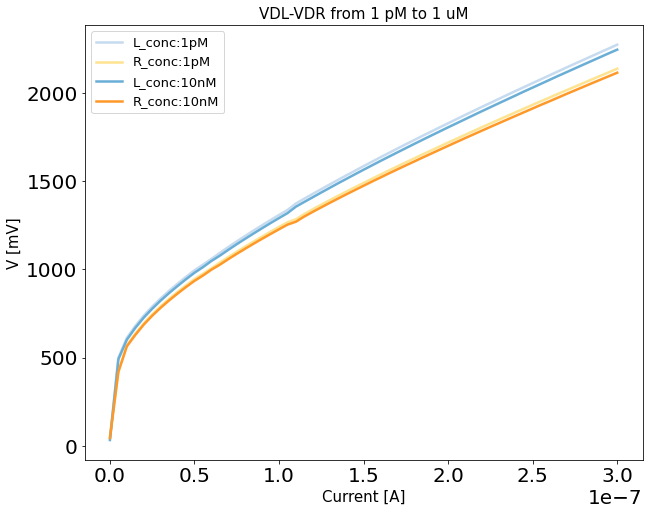

In [32]:
fig, ax = plt.subplots(figsize = (10,8))
#for i,df in enumerate(subset_dfs):
for i,concen in enumerate([1,-3]):
    ax.plot(lists_of_df[concen][-1]['IDL'], (lists_of_df[concen][-1]['VDL'])*1000, label = 'L_conc:'+str(conc[concen]), color = colors_L[i], linewidth = 2.5)
    ax.plot(lists_of_df[concen][-1]['IDR'], (lists_of_df[concen][-1]['VDR'])*1000, label = 'R_conc:'+str(conc[concen]), color = colors_R[i], linewidth = 2.5)

ax.set_xlabel('Current [A]',fontsize = 15)
ax.set_ylabel('V [mV]',fontsize = 15)
ax.legend(fontsize = 13)
plt.title('VDL-VDR from 1 pM to 1 uM',fontsize = 15)
plt.rcParams.update({'font.size': 20})
plt.show()

# End of code